#  Various packages

In [1]:
import sys
import numpy as np
import pandas as pd 
import seaborn as sns

import matplotlib.pyplot as plt

#from numpy.core.umath_tests import inner1d
# modelos

from sklearn.svm import SVC
from matplotlib import pyplot
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import  ExtraTreesClassifier,VotingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


from sklearn.metrics import accuracy_score,roc_auc_score, f1_score,classification_report,precision_score,recall_score
from sklearn.model_selection import cross_val_score,  RepeatedStratifiedKFold,RandomizedSearchCV, GridSearchCV



# Importing data

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,0,0,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,1,1,202.21,0.0,0,1
2,31112,1,80.0,0,1,1,0,1,105.92,32.5,0,1
3,60182,0,49.0,0,0,1,0,0,171.23,34.4,2,1
4,1665,0,79.0,1,0,1,1,1,174.12,24.0,0,1


# Pre-processing  

In [4]:
# Data1 : without id
data = data.drop(['id'], axis=1)

In [5]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [6]:
data.work_type.value_counts()

0               2925
1                819
children         687
2                657
Never_worked      22
Name: work_type, dtype: int64

In [7]:
label = [1,2,3,4,5]
data["age_mean"] = pd.cut(data["age"], 5, labels = label)
data["age_mean"].value_counts()
# Age stages were divided into five groups and the mean bmi was calculated separately
bmi_group = data.groupby("age_mean")["bmi"].mean() 
bmi_group

age_mean
1    20.317588
2    27.889394
3    30.359831
4    30.363052
5    27.220415
Name: bmi, dtype: float64

In [8]:
#Give bmi mean age-specific assignments
def bmi_val(cols): 
    bmi = cols[0]
    age_mean = cols[1]
    
    if pd.isnull(bmi):
        if age_mean == 1:
            return 20.7
        elif age_mean == 2:
            return 28.6
        elif age_mean == 3:
            return 31.4
        elif age_mean == 4:
            return 31.6
        elif age_mean == 5:
            return 29.4
    else:
        return bmi

In [9]:
data["bmi"] = data[["bmi","age_mean"]].apply(bmi_val, axis=1)

In [10]:
data.isnull().sum() 

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_mean             0
dtype: int64

In [11]:
#Change other to Female
data.gender = data.gender.apply(lambda x: 0 
                                if ((x == 'Female') or (x == 'Other')) 
                                else 1)

In [12]:
data.gender.value_counts()

1    5109
0       1
Name: gender, dtype: int64

In [13]:
data['age'] = data['age'].apply(lambda x: round(x))
data['age']

0       67
1       61
2       80
3       49
4       79
        ..
5105    80
5106    81
5107    35
5108    51
5109    44
Name: age, Length: 5110, dtype: int64

In [14]:
Feature = data.columns
Feature

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_mean'],
      dtype='object')

# Data type conversion

In [15]:
# transformer = ColumnTransformer(transformers=[('imp',SimpleImputer(strategy='median'),numerical),('o',OneHotEncoder(),categorical)])
# pipeline = Pipeline(steps=[('t', transformer),('p',PowerTransformer(method='yeo-johnson')),('m', LR)])    
# scores = evaluate_model(X, y, pipeline)
# # results.append(scores)
# # print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# scores

In [16]:
data.select_dtypes('object')

,work_type
0,0
1,1
2,0
3,0
4,1
...,...
5105,0
5106,1
5107,1
5108,0


# The latest changes


In [17]:
data.select_dtypes('object')

,work_type
0,0
1,1
2,0
3,0
4,1
...,...
5105,0
5106,1
5107,1
5108,0


In [18]:
for i in range(len(data.ever_married)):
    if data.ever_married[i] == 'Yes':
        data.ever_married[i] = 1
    elif data.ever_married[i] == 'No':
        data.ever_married[i] = 0
print(data.ever_married)

0       1
1       1
2       1
3       1
4       1
       ..
5105    1
5106    1
5107    1
5108    1
5109    1
Name: ever_married, Length: 5110, dtype: int64


## Work_type

In [19]:
for i in range(len(data.work_type)):
    if data.work_type[i] == 'Private':
        data.work_type[i] = 0
    elif data.work_type[i] == 'Self-employed':
        data.work_type[i] = 1
    elif data.work_type[i] == 'children':
        data.work_type[i] = 2
    elif data.work_type[i] == 'Govt_job':
        data.work_type[i] = 3
    elif data.work_type[i] == 'Never_worked':
        data.work_type[i] = 4
        
print(data.work_type)

0       0
1       1
2       0
3       0
4       1
       ..
5105    0
5106    1
5107    1
5108    0
5109    2
Name: work_type, Length: 5110, dtype: object

<ipython-input-19-1b13aa098b83>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.work_type[i] = 2
<ipython-input-19-1b13aa098b83>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.work_type[i] = 4


## Residence_type

In [20]:
for i in range(len(data.Residence_type)):
    if data.Residence_type[i] == 'Urban':
        data.Residence_type[i] = 0
    elif data.Residence_type[i] == 'Rural':
        data.Residence_type[i] = 1

print(data.Residence_type)

0       0
1       1
2       1
3       0
4       1
       ..
5105    0
5106    0
5107    1
5108    1
5109    0
Name: Residence_type, Length: 5110, dtype: int64


## 	Smoking_status

In [21]:
for i in range(len(data.smoking_status)):
    if data.smoking_status[i] == 'never smoked':
        data.smoking_status[i] = 0
    elif data.smoking_status[i] == 'Unknown':
        data.smoking_status[i] = 1
    elif data.smoking_status[i] == 'formerly smoked':
        data.smoking_status[i] = 2
    elif data.smoking_status[i] == 'smokes':
        data.smoking_status[i] = 3       
print(data.smoking_status)

0       1
1       0
2       0
3       2
4       0
       ..
5105    0
5106    0
5107    0
5108    1
5109    3
Name: smoking_status, Length: 5110, dtype: int64


In [22]:
X = data.drop(columns=['stroke','age_mean'])
y = data['stroke']

In [23]:
X.isnull().sum() 

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

In [24]:
smote=SMOTE(random_state=42)
x_smote,y_smote=smote.fit_resample(X,y)

In [25]:
X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.33,random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [26]:
# Rescaling Data
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
for i in range(len(X_train)):
    sample= X_train[i]
    for j in range(len(sample)):
        if np.isnan(sample[j]):
            sample[j]=0 

print(np.isnan(X_train).any())
            
for i in range(len(X_test)):
    sample= X_test[i]
    for j in range(len(sample)):
        if np.isnan(sample[j]):
            sample[j]=0 
print(np.isnan(X_test).any())

False
False


In [49]:
# NB have smote
from sklearn.naive_bayes import BernoulliNB
NB=BernoulliNB()
NB.fit(X_train,y_train)
predict_results=NB.predict(X_test)
print(accuracy_score(predict_results, y_test))
conf_mat = confusion_matrix(y_test, predict_results)
print(conf_mat)
print(classification_report(y_test, predict_results))


0.773208722741433
[[586 217]
 [147 655]]
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       803
           1       0.75      0.82      0.78       802

    accuracy                           0.77      1605
   macro avg       0.78      0.77      0.77      1605
weighted avg       0.78      0.77      0.77      1605



In [52]:
#LR
LR=LogisticRegression()
LR.fit(X_train,y_train)
#Important features of the model
n=LR.coef_
print(n)
y_pred=LR.predict(X_test)
# print(y_pred)

[[ 0.05969336  1.93506517 -0.29407032 -0.24782297 -0.34732426 -0.17012681
  -0.56559187  0.40188952 -0.23537644 -0.31702504]]


In [30]:
class_report=classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       803
           1       0.80      0.82      0.81       802

    accuracy                           0.81      1605
   macro avg       0.81      0.81      0.81      1605
weighted avg       0.81      0.81      0.81      1605



In [53]:
#Select the most accurate kernels of SVC
kernels = ['rbf','linear','poly','sigmoid']
model = SVC()
hyperparam = [{'kernel':kernels}]
model = GridSearchCV(SVC(),hyperparam,cv=5,verbose=1)
best_model=model.fit(X_train,y_train)
pre_svc = best_model.best_estimator_.predict(X_test)

model1 = SVC(kernel = 'linear')
model1.fit(X_train, y_train)
# pre_svc = model1.predict(X_test)
print(classification_report(y_test, pre_svc))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       803
           1       0.83      0.88      0.85       802

    accuracy                           0.85      1605
   macro avg       0.85      0.85      0.85      1605
weighted avg       0.85      0.85      0.85      1605



In [32]:
# #using smote
# f1_NB = f1_score(y_test, predict_results,average='macro') 
# print(f1_NB)
# f1_LR = f1_score(y_test, y_pred,average='macro') 
# print(f1_LR)
# f1_SVM = f1_score(y_test, pre_svc,average='macro') 
# print(f1_SVM)

In [54]:
# Initialization RandomForest algorithm (find the best parameters)
rf = RandomForestClassifier()

n_estimators = [100,500,700,1000]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

grid =         {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

search_rf = RandomizedSearchCV(estimator = rf, param_distributions = grid, cv = 5, verbose=1, n_jobs=-1)
# training dataset, construct model
search_rf.fit(X_train, y_train)
# test models. 
preds_rf = search_rf.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [34]:
# result of RF on SMOTE dataset
print("Random Forest:")
print(classification_report(y_test, preds_rf))  # 'Random Forest:',

Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       803
           1       0.96      0.95      0.95       802

    accuracy                           0.95      1605
   macro avg       0.95      0.95      0.95      1605
weighted avg       0.95      0.95      0.95      1605



In [55]:
#using smote
f1_NB = f1_score(y_test, predict_results,average='macro') 
print(f1_NB)
f1_LR = f1_score(y_test, y_pred,average='macro') 
print(f1_LR)
f1_SVM = f1_score(y_test, pre_svc,average='macro') 
print(f1_SVM)
f1_RF = f1_score(y_test, preds_rf,average='macro') 
print(f1_RF)

0.7727887918160097
0.8055741921055573
0.8465974257678094
0.9532707377963353


# Smote

In [36]:
# m=NB.coef_
# print(m)
# import matplotlib.pyplot as plt
# #The horizontal coordinate is the class. The vertical is n
# # len(n[0])--16
# plt.figure(figsize=(21,10))
# # plt.subplot(121)
# plt.bar(X.columns,m[0])
# plt.title('import features')
# plt.show()


In [37]:
X_train_1,X_test_1, y_train_1,y_test_1=train_test_split(X,y,test_size=0.33,random_state=42)

In [38]:
# NB no smote
from sklearn.naive_bayes import BernoulliNB
NB1=BernoulliNB()
NB1.fit(X_train_1,y_train_1)
predict_results=NB1.predict(X_test_1)
print(accuracy_score(predict_results, y_test_1))
conf_mat = confusion_matrix(y_test_1, predict_results)
print(conf_mat)
print(classification_report(y_test_1, predict_results))


0.939537640782454
[[1584    7]
 [  95    1]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1591
           1       0.12      0.01      0.02        96

    accuracy                           0.94      1687
   macro avg       0.53      0.50      0.49      1687
weighted avg       0.90      0.94      0.91      1687



In [39]:
# n=NB1.coef_
# print(n)
# import matplotlib.pyplot as plt
# #The horizontal coordinate is the class. The vertical is n
# # len(n[0])--16
# plt.figure(figsize=(21,10))
# # plt.subplot(121)
# plt.bar(X.columns,n[0])
# plt.title('import features')
# plt.show()


In [40]:
#LR
LR=LogisticRegression()
LR.fit(X_train_1,y_train_1)
#Important features of the model
n=LR.coef_
print(n)
y_pred=LR.predict(X_test_1)
# print(y_pred)

[[-2.71628847  0.06517718  0.45895967  0.3676914  -0.67261444 -0.20116053
  -0.03371364  0.00416453 -0.03884263  0.00603218]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
class_report=classification_report(y_test_1,predict_results)
print(class_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1591
           1       0.12      0.01      0.02        96

    accuracy                           0.94      1687
   macro avg       0.53      0.50      0.49      1687
weighted avg       0.90      0.94      0.91      1687



In [42]:
#Select the most accurate kernels of SVC
kernels = ['rbf','linear','poly','sigmoid']
model = SVC()
hyperparam = [{'kernel':kernels}]
model = GridSearchCV(SVC(),hyperparam,cv=5,verbose=1)
best_model=model.fit(X_train_1,y_train_1)
pre_svc_1 = best_model.best_estimator_.predict(X_test_1)


print(classification_report(y_test_1, pre_svc_1))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1591
           1       0.00      0.00      0.00        96

    accuracy                           0.94      1687
   macro avg       0.47      0.50      0.49      1687
weighted avg       0.89      0.94      0.92      1687



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
#  Random Forest
rf.fit(X_train_1, y_train_1)
preds_rf_or = search_rf.predict(X_test_1)

print(classification_report(y_test_1, preds_rf_or))  # 'Random Forest:',

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1591
           1       0.08      0.30      0.12        96

    accuracy                           0.75      1687
   macro avg       0.51      0.54      0.49      1687
weighted avg       0.90      0.75      0.81      1687



In [44]:
# #whole
# from sklearn.metrics import f1_score
# #print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
# f1 = f1_score(y_test_1, predict_results,average='macro') 
# print(f1)
# from sklearn.metrics import accuracy_score
# #print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
# accuracy1 = accuracy_score(y_test_1, predict_results) 
# print(accuracy1)

In [56]:
# #using smote
# f1_NB = f1_score(y_test, predict_results) 
# print(f1_NB)
# f1_LR = f1_score(y_test, y_pred) 
# print(f1_LR)
# f1_SVM = f1_score(y_test, pre_svc) 
# print(f1_SVM)
# f1_RF = f1_score(y_test, preds_rf) 
# print(f1_RF)

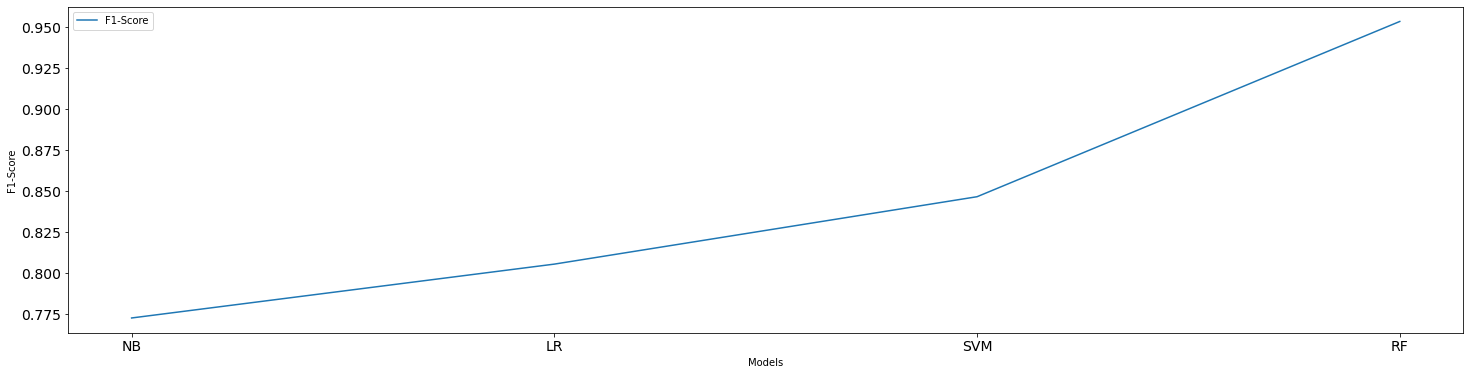

In [57]:
plt.figure(figsize=[25,6])
plt.tick_params(labelsize=14)
xx = ['NB','LR','SVM','RF']
yy = [f1_NB,f1_LR,f1_SVM,f1_RF]
plt.plot(xx, yy, label = 'F1-Score')
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.legend()